In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms as T

import sys
import os
# Add the directory to sys.path
os.chdir("/zhome/b6/d/154958/Video_detection/Video_classification")
datasets_dir = '/dtu/blackhole/16/155094/Video_classification'
sys.path.append(datasets_dir)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
class FrameImageDataset(torch.utils.data.Dataset):
    def __init__(self, 
    root_dir='/dtu/blackhole/16/155094/ufc101',
    split='train', 
    transform=None
):
        self.frame_paths = sorted(glob(f'{root_dir}/frames/{split}/*/*/*.jpg'))
        self.root_dir = root_dir
        self.split = split
        self.df = pd.read_csv(f'{root_dir}/metadata/{split}.csv')
        self.split = split
        self.transform = transform
       
    def __len__(self):
        return len(self.frame_paths)

    def _get_meta(self, attr, value):
        return self.df.loc[self.df[attr] == value]

    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        
        

        
        video_name = frame_path.split('/')[-2]
        video_meta = self._get_meta('video_name', video_name)
        label = video_meta['label'].item()
        
        the_split = frame_path.split("/")
        
        first = the_split[-3]
        second = the_split[-2]
        
        flow_paths = sorted(glob(f'{self.root_dir}/flows/{self.split}/{first}/{second}/*.npy'))
        frame = Image.open(frame_path).convert("RGB")

        if self.transform:
            frame = self.transform(frame)
        else:
            frame = T.ToTensor()(frame)

        flow_tensor = [torch.from_numpy(np.load(x)) for x in flow_paths]
        label = torch.tensor(label, dtype = torch.long)
        return frame, label, flow_tensor, video_name,second

In [4]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
batch_size = 64

# Dataset directories
root_dir = '/dtu/datasets1/02516/ucf101_noleakage'

# Initialize datasets
train_dataset = FrameImageDataset(root_dir=root_dir, split='train', transform=transform)
val_dataset = FrameImageDataset(root_dir=root_dir, split='val', transform=transform)
test_dataset = FrameImageDataset(root_dir=root_dir, split='test', transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for frame, label, flow_tensor, video_name,first in train_loader:
    print(video_name)
    print(first)
    break

('v_BodyWeightSquats_g17_c04', 'v_HandStandPushups_g21_c06', 'v_HandStandPushups_g20_c06', 'v_TrampolineJumping_g21_c02', 'v_BodyWeightSquats_g23_c03', 'v_PushUps_g18_c01', 'v_JumpRope_g14_c03', 'v_JumpRope_g14_c04', 'v_WallPushups_g17_c05', 'v_HandStandPushups_g15_c05', 'v_WallPushups_g12_c04', 'v_PullUps_g20_c02', 'v_HandStandPushups_g21_c01', 'v_PushUps_g14_c01', 'v_HandStandPushups_g15_c01', 'v_WallPushups_g20_c02', 'v_HandStandPushups_g15_c01', 'v_TrampolineJumping_g12_c04', 'v_HandStandPushups_g11_c05', 'v_PullUps_g09_c03', 'v_JumpingJack_g14_c03', 'v_Lunges_g21_c02', 'v_JumpRope_g11_c02', 'v_Lunges_g14_c05', 'v_HandstandWalking_g14_c03', 'v_TrampolineJumping_g20_c04', 'v_JumpingJack_g09_c05', 'v_PullUps_g18_c02', 'v_PullUps_g23_c01', 'v_PullUps_g17_c04', 'v_JumpRope_g18_c01', 'v_WallPushups_g10_c03', 'v_WallPushups_g21_c06', 'v_Lunges_g17_c01', 'v_JumpingJack_g09_c01', 'v_TrampolineJumping_g09_c02', 'v_JumpRope_g12_c04', 'v_PullUps_g10_c03', 'v_PushUps_g21_c02', 'v_BodyWeightSqu

In [7]:
import timm
class FusionStreamModel_CNN(nn.Module):
    def __init__(self, num_classes=10, input_channels= 3, dropOutVal = 0.5):
        super(FusionStreamModel_CNN, self).__init__()
        
        
    
       # Convolutional Feature Extraction
        self.backbone_Temporal = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            nn.Flatten(),
            
            nn.Sequential(
            nn.Linear(12544, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes) 
        ))

        
        # Convolutional Feature Extraction
        self.backbone_Spatial = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Flatten(),
            
            nn.Sequential(
            nn.Linear(12544, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes) 
        ))
        


    def forward(self, frame,flow):
        # Extract features using EfficientNet
        
        spatial = self.backbone_Spatial(frame)
        spatial = torch.softmax(spatial, dim= 1)
        
        temporal = self.backbone_Temporal(flow)
        temporal = torch.softmax(temporal, dim= 1)
        
        output = torch.stack((spatial,temporal)).mean(dim=0)
        
        return output

In [45]:
class SpatialStream(nn.Module):
    def __init__(self, num_classes):
        super(SpatialStream, self).__init__()
        # Load a pretrained backbone (ResNet-18)
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, drop_rate = 0.9,drop_path_rate=0.9)  # Remove final layer
        self.DropOut = nn.Dropout(0.5)
        self.fc = nn.Linear(self.backbone.num_features, num_classes)  # Add a new classification layer

    def forward(self, x):
        x = self.backbone(x)  # Extract features using pretrained backbone
        # x = self.DropOut(x)
        x = self.fc(x)        # Classification layer
        return x


# Temporal Stream (pretrained backbone adapted for optical flow)
class TemporalStream(nn.Module):
    def __init__(self, num_classes, num_frames):
        super(TemporalStream, self).__init__()
        self.backbone = timm.create_model('resnet34', pretrained=True, num_classes=0)  # Remove final layer

        # Adapt the first convolutional layer to handle 2*num_frames input channels
        self.backbone.conv1 = nn.Conv2d(
            in_channels=2 * num_frames,  # Optical flow stack
            out_channels=self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False
        )
        self.fc = nn.Linear(self.backbone.num_features, num_classes)  # Add a new classification layer

    def forward(self, x):
        x = self.backbone(x)  # Extract features using pretrained backbone
        x = self.fc(x)        # Classification layer
        return x

# Two-stream network
class TwoStreamFusion(nn.Module):
    def __init__(self, num_classes, num_frames, temporal_weight=0.7):
        super(TwoStreamFusion, self).__init__()
        self.spatial_stream = SpatialStream(num_classes)
        self.temporal_stream = TemporalStream(num_classes, num_frames)
        self.temporal_weight = temporal_weight  # Weight for temporal stream

    def forward(self, spatial_input, temporal_input):
        spatial_logits = torch.sigmoid(self.spatial_stream(spatial_input))
        temporal_logits = torch.sigmoid(self.temporal_stream(temporal_input))
        # print(temporal_logits[0])

        # Weighted fusion
        fused_logits = (self.temporal_weight * temporal_logits) + ((1 - self.temporal_weight) * spatial_logits)
        return fused_logits

In [46]:

# # model = FusionStreamModel_CNN(input_channels=18)
# # Loss and Optimizer
# model = TwoStreamFusion(num_classes=10, num_frames = 9)
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()



In [51]:

# model = FusionStreamModel_CNN(input_channels=18)
# Loss and Optimizer
model = TwoStreamFusion(num_classes=10, num_frames = 9, temporal_weight=0.7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

# Training Spatial Stream
spatial_train_loss_history = []
spatial_train_acc_history = []
spatial_val_loss_history = []
spatial_val_acc_history = []

# Training Temporal Stream
temporal_train_loss_history = []
temporal_train_acc_history = []
temporal_val_loss_history = []
temporal_val_acc_history = []

# Loop to train spatial and temporal streams separately
epochs = 20
for epoch in range(epochs):
    print(f"Epoch [{epoch + 1}/{epochs}]")
    

    ### Train Temporal Stream ###
    model.temporal_stream.train()
    temporal_running_loss = 0.0
    temporal_correct = 0
    temporal_total = 0

    for _, labels, flow_tensor,_,_ in train_loader:  # Only need `flow_tensor` and `labels`
        flow_tensor = torch.cat(flow_tensor, dim=1)
        flow_tensor, labels = flow_tensor.to(device), labels.to(device)

        outputs = model.temporal_stream(flow_tensor)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        temporal_running_loss += loss.item()
        _, predicted = outputs.max(1)
        temporal_total += labels.size(0)
        temporal_correct += predicted.eq(labels).sum().item()

    temporal_train_loss = temporal_running_loss / len(train_loader)
    temporal_train_acc = 100 * temporal_correct / temporal_total
    temporal_train_loss_history.append(temporal_train_loss)
    temporal_train_acc_history.append(temporal_train_acc)

    print(f"Temporal Stream - Train Loss: {temporal_train_loss:.4f}, Train Accuracy: {temporal_train_acc:.2f}%")
    
    ### Validate Temporal Stream ###
    model.temporal_stream.eval()
    temporal_val_loss = 0.0
    temporal_correct = 0
    temporal_total = 0
    with torch.no_grad():
        for _, labels, flow_tensor,_,_ in val_loader:  # Only need `flow_tensor` and `labels`
            flow_tensor = torch.cat(flow_tensor, dim=1)
            flow_tensor, labels = flow_tensor.to(device), labels.to(device)

            outputs = model.temporal_stream(flow_tensor)
            loss = criterion(outputs, labels)

            temporal_val_loss += loss.item()
            _, predicted = outputs.max(1)
            temporal_total += labels.size(0)
            temporal_correct += predicted.eq(labels).sum().item()

    temporal_val_loss /= len(val_loader)
    temporal_val_acc = 100 * temporal_correct / temporal_total
    temporal_val_loss_history.append(temporal_val_loss)
    temporal_val_acc_history.append(temporal_val_acc)

    print(f"Temporal Stream - Val Loss: {temporal_val_loss:.4f}, Val Accuracy: {temporal_val_acc:.2f}%")
    
    
    if epoch > 14:
        continue
    ### Train Spatial Stream ###
    model.spatial_stream.train()
    spatial_running_loss = 0.0
    spatial_correct = 0
    spatial_total = 0

    for frame, labels, _,_,_ in train_loader:  # Only need `frame` and `labels`
        frame, labels = frame.to(device), labels.to(device)

        outputs = model.spatial_stream(frame)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        spatial_running_loss += loss.item()
        _, predicted = outputs.max(1)
        spatial_total += labels.size(0)
        spatial_correct += predicted.eq(labels).sum().item()

    spatial_train_loss = spatial_running_loss / len(train_loader)
    spatial_train_acc = 100 * spatial_correct / spatial_total
    spatial_train_loss_history.append(spatial_train_loss)
    spatial_train_acc_history.append(spatial_train_acc)

    print(f"Spatial Stream - Train Loss: {spatial_train_loss:.4f}, Train Accuracy: {spatial_train_acc:.2f}%")
    
    ### Validate Spatial Stream ###
    model.spatial_stream.eval()
    spatial_val_loss = 0.0
    spatial_correct = 0
    spatial_total = 0
    with torch.no_grad():
        for frame, labels, _,_,_ in val_loader:  # Only need `frame` and `labels`
            frame, labels = frame.to(device), labels.to(device)

            outputs = model.spatial_stream(frame)
            loss = criterion(outputs, labels)

            spatial_val_loss += loss.item()
            _, predicted = outputs.max(1)
            spatial_total += labels.size(0)
            spatial_correct += predicted.eq(labels).sum().item()

    spatial_val_loss /= len(val_loader)
    spatial_val_acc = 100 * spatial_correct / spatial_total
    spatial_val_loss_history.append(spatial_val_loss)
    spatial_val_acc_history.append(spatial_val_acc)

    print(f"Spatial Stream - Val Loss: {spatial_val_loss:.4f}, Val Accuracy: {spatial_val_acc:.2f}%")

# During evaluation, use both spatial and temporal streams to compute fused logits.


Epoch [1/20]
Temporal Stream - Train Loss: 2.2892, Train Accuracy: 10.50%
Temporal Stream - Val Loss: 2.2761, Val Accuracy: 13.33%
Spatial Stream - Train Loss: 2.3687, Train Accuracy: 11.28%
Spatial Stream - Val Loss: 2.2536, Val Accuracy: 20.08%
Epoch [2/20]
Temporal Stream - Train Loss: 2.2262, Train Accuracy: 24.04%
Temporal Stream - Val Loss: 2.2206, Val Accuracy: 24.17%
Spatial Stream - Train Loss: 2.2516, Train Accuracy: 17.24%
Spatial Stream - Val Loss: 2.1836, Val Accuracy: 31.42%
Epoch [3/20]
Temporal Stream - Train Loss: 2.1719, Train Accuracy: 36.52%
Temporal Stream - Val Loss: 2.1835, Val Accuracy: 28.33%
Spatial Stream - Train Loss: 2.1276, Train Accuracy: 23.76%
Spatial Stream - Val Loss: 2.1067, Val Accuracy: 36.42%
Epoch [4/20]
Temporal Stream - Train Loss: 2.1173, Train Accuracy: 43.60%
Temporal Stream - Val Loss: 2.1337, Val Accuracy: 35.00%
Spatial Stream - Train Loss: 1.9458, Train Accuracy: 33.66%
Spatial Stream - Val Loss: 1.9405, Val Accuracy: 43.83%
Epoch [5/20]

In [52]:
file = open("fusion_two_stream.pkl", "wb")
torch.save(model, file)

In [55]:
model = torch.load("fusion_two_stream.pkl")

/tmp/ipykernel_147830/3120883314.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fusion_two_stream.pkl")


In [56]:
# # Fine tuning each model together
# model = TwoStreamFusion(num_classes=10, num_frames = 9, temporal_weight=0.7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

# Metrics storage
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training and Validation Loop
epochs = 3
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for frame, labels, flow_tensor,_,_ in train_loader:
        flow_tensor = torch.cat(flow_tensor,dim=1)     
        frame, labels, flow_tensor = frame.to(device), labels.to(device), flow_tensor.to(device)
   
        outputs = model(frame,flow_tensor)

        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    # scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for frame, labels, flow_tensor,_,_ in val_loader:
            
            flow_tensor = torch.cat(flow_tensor,dim=1)     
            frame, labels, flow_tensor = frame.to(device), labels.to(device), flow_tensor.to(device)
            
     

            outputs = model(frame, flow_tensor)
            # print(outputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Epoch [1/3]
Train Loss: 1.9319, Train Accuracy: 96.14%
Val Loss: 2.0995, Val Accuracy: 63.33%
Epoch [2/3]
Train Loss: 1.9750, Train Accuracy: 94.02%
Val Loss: 2.1161, Val Accuracy: 61.58%
Epoch [3/3]
Train Loss: 1.9934, Train Accuracy: 93.58%
Val Loss: 2.1319, Val Accuracy: 60.00%


In [57]:
import matplotlib.pyplot as plt

def plot_training_validation_metrics(spatial_train_loss, spatial_val_loss, spatial_train_acc, spatial_val_acc,
                                     temporal_train_loss, temporal_val_loss, temporal_train_acc, temporal_val_acc):
    epochs_spat = range(1, len(spatial_train_loss) + 1)
    epochs_temp = range(1, len(temporal_train_loss) + 1)
    print(epochs_temp)
    # Plot Spatial Stream Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_spat, spatial_train_loss, label='Spatial Train Loss', marker='o')
    plt.plot(epochs_spat, spatial_val_loss, label='Spatial Validation Loss', marker='o')
    plt.title('Spatial Stream Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Spatial Stream Accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_spat, spatial_train_acc, label='Spatial Train Accuracy', marker='o')
    plt.plot(epochs_spat, spatial_val_acc, label='Spatial Validation Accuracy', marker='o')
    plt.title('Spatial Stream Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Temporal Stream Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_temp, temporal_train_loss, label='Temporal Train Loss', marker='o')
    plt.plot(epochs_temp, temporal_val_loss, label='Temporal Validation Loss', marker='o')
    plt.title('Temporal Stream Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Temporal Stream Accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_temp, temporal_train_acc, label='Temporal Train Accuracy', marker='o')
    plt.plot(epochs_temp, temporal_val_acc, label='Temporal Validation Accuracy', marker='o')
    plt.title('Temporal Stream Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


range(1, 21)


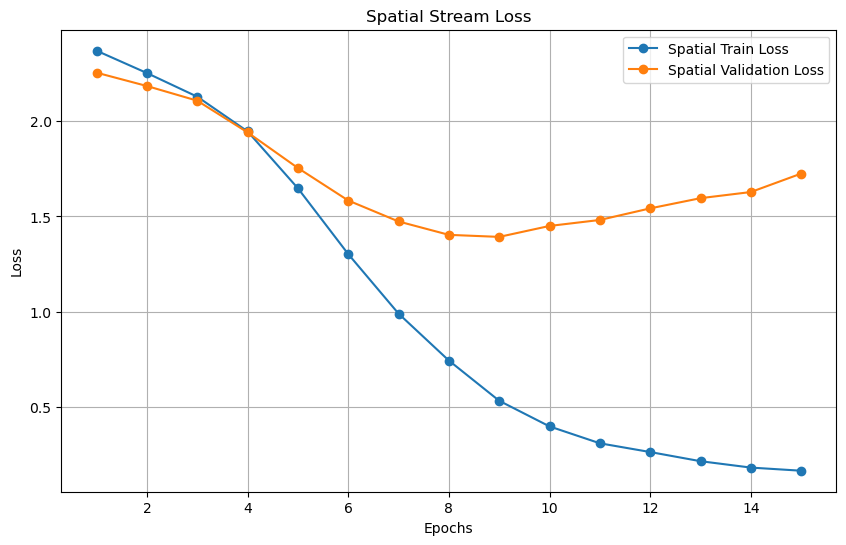

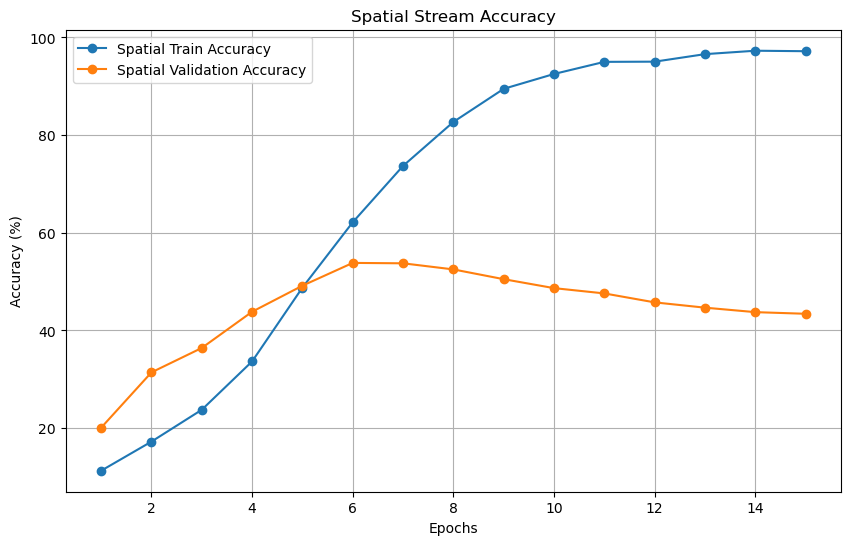

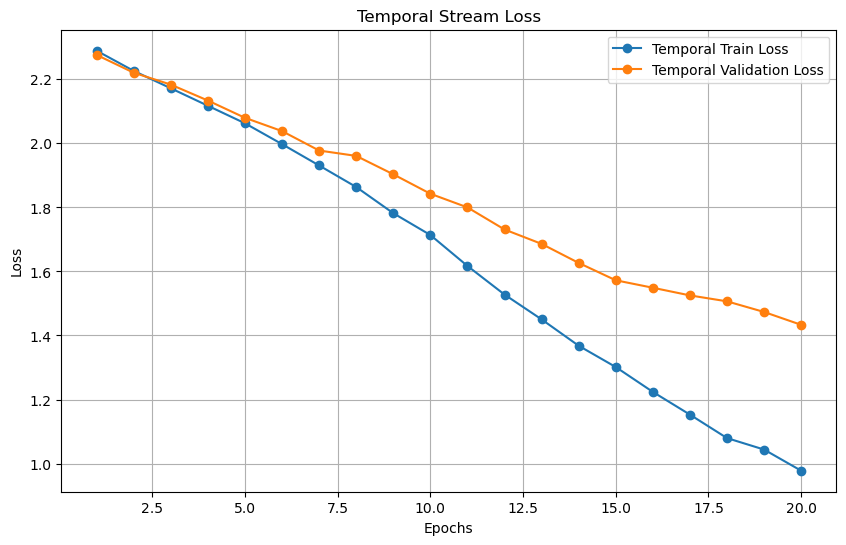

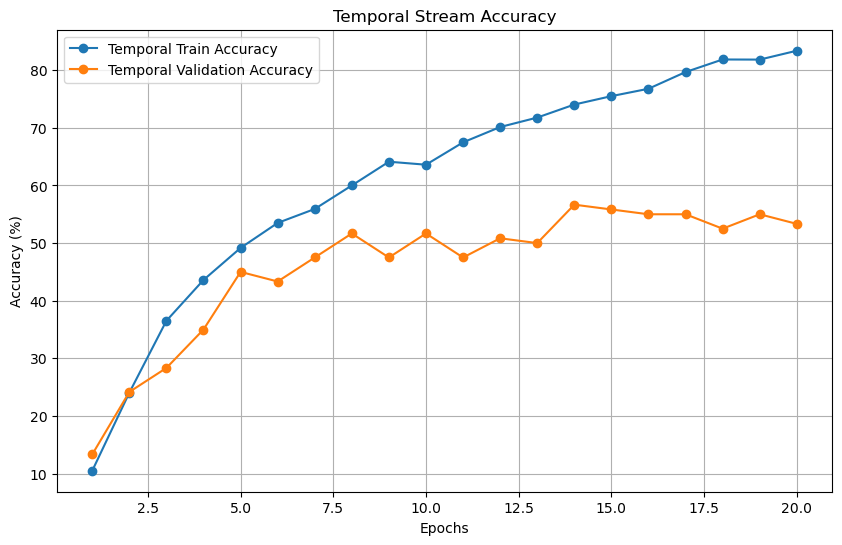

In [58]:
plot_training_validation_metrics(
    spatial_train_loss_history, spatial_val_loss_history, 
    spatial_train_acc_history, spatial_val_acc_history,
    temporal_train_loss_history, temporal_val_loss_history,
    temporal_train_acc_history, temporal_val_acc_history
)


In [59]:
test_loss = 0
test_acc = 0
correct = 0
total = 0

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for frame, labels, flow_tensor, _, _ in test_loader:  # Use test_loader for testing
        # Prepare inputs and move to the appropriate device
        flow_tensor = torch.cat(flow_tensor, dim=1)     
        frame, labels, flow_tensor = frame.to(device), labels.to(device), flow_tensor.to(device)
        
        # Forward pass
        outputs = model(frame, flow_tensor)
        loss = criterion(outputs, labels)
        
        # Update test loss
        test_loss += loss.item()
        
        # Calculate predictions and update metrics
        _, predicted = outputs.max(1)  # Get the class with the highest score
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_acc = 100 * correct / total

# Print test metrics
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 2.1346, Test Accuracy: 64.17%


In [60]:
test_loss = 0
test_acc = 0
correct = 0
total = 0
model = torch.load("fusion_two_stream.pkl")
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for efficiency
    for frame, labels, flow_tensor, _, _ in test_loader:  # Use test_loader for testing
        # Prepare inputs and move to the appropriate device
        flow_tensor = torch.cat(flow_tensor, dim=1)     
        frame, labels, flow_tensor = frame.to(device), labels.to(device), flow_tensor.to(device)
        
        # Forward pass
        outputs = model(frame, flow_tensor)
        loss = criterion(outputs, labels)
        
        # Update test loss
        test_loss += loss.item()
        
        # Calculate predictions and update metrics
        _, predicted = outputs.max(1)  # Get the class with the highest score
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_acc = 100 * correct / total

# Print test metrics
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

/tmp/ipykernel_147830/2071941437.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("fusion_two_stream.pkl")


Test Loss: 2.0522, Test Accuracy: 65.50%
